In [1]:
#Import Dependencies
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import datetime as dt
import numpy as np
from collections import Counter 

In [2]:
#Load Data
#Will be database connection, don't have that yet

In [21]:
#temporary
data=pd.read_csv("Resources/merged_AKC.csv")
data.head()

,Animal ID,Intake_Type,Intake_Condition,Breed,Color,Age_in_Years,Intactness,Sex,Age,Breed_Type,...,Breed_update,Breed1,Breed2,AKC_group1,Size1,AKC_group2,Size2,Sorted_Color,Restricted,Multiple_Intakes
0,A006100,Public Assist,Normal,Spinone Italiano Mix,Yellow/White,6.0,Altered,Male,Adult,Mix,...,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,0
1,A006100,Public Assist,Normal,Spinone Italiano Mix,Yellow/White,7.0,Altered,Male,Adult,Mix,...,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
2,A006100,Stray,Normal,Spinone Italiano Mix,Yellow/White,10.0,Altered,Male,Senior,Mix,...,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
3,A047759,Owner Surrender,Normal,Dachshund,Tricolor,10.0,Altered,Male,Senior,Pure,...,Dachshund,Dachshund,NaN,hound,small,NaN,NaN,Tricolor,No,0
4,A134067,Public Assist,Injured,Shetland Sheepdog,Brown/White,16.0,Altered,Male,Senior,Pure,...,Shetland Sheepdog,Shetland Sheepdog,NaN,herding,small,NaN,NaN,Brown/White,No,0


In [22]:
#Create string labels for months, to aid with dummy coding later

data["in_Month"]=data["in_Month"].astype(str)
nums=("1","2","3","4","5","6","7","8","9","10","11","12")
months=("Jan","Feb","Mar","Apr","May","June","July","Aug","Sep","Oct","Nov","Dec")
data["in_Month"]= data["in_Month"].replace(nums,months)


In [23]:
#Drop original columns not needed
data=data.drop(columns=["Animal ID","Breed", "Color", "Age_in_Years"])

In [24]:
#Drop rows where Outcome Type is missing or labeled "Missing", disposal and rto-adopt
data=data.dropna(subset=["Outcome_Type"])
data=data.drop(data[data["Outcome_Type"]=="Missing"].index)
data=data.drop(data[data["Outcome_Type"]=="Disposal"].index)
data=data.drop(data[data["Outcome_Type"]=="Rto-Adopt"].index)

In [25]:
#rename columns to shorten
data=data.rename(columns={"Intake_Type": "Type", "Intake_Condition": "Cond",
                          "Outcome_Type":"Outcome", "Length_of_Stay":"LS", "in_Month":"m", "in_Year":"y",
                          "AKC_group1":"group1", "AKC_group2": "group2", "Sorted_Color":"color"})
data.head()

,Type,Cond,Intactness,Sex,Age,Breed_Type,Outcome,LS,m,y,Breed_update,Breed1,Breed2,group1,Size1,group2,Size2,color,Restricted,Multiple_Intakes
0,Public Assist,Normal,Altered,Male,Adult,Mix,Return to Owner,2,Mar,2014,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,0
1,Public Assist,Normal,Altered,Male,Adult,Mix,Return to Owner,2,Dec,2014,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
2,Stray,Normal,Altered,Male,Senior,Mix,Return to Owner,1,Dec,2017,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
3,Owner Surrender,Normal,Altered,Male,Senior,Pure,Transfer,6,Apr,2014,Dachshund,Dachshund,NaN,hound,small,NaN,NaN,Tricolor,No,0
4,Public Assist,Injured,Altered,Male,Senior,Pure,Return to Owner,1,Nov,2013,Shetland Sheepdog,Shetland Sheepdog,NaN,herding,small,NaN,NaN,Brown/White,No,0


In [26]:
#Look at quartiles for length of stay
print(data["LS"].describe())

count    75218.000000
mean        18.810391
std         48.375331
min          1.000000
25%          3.000000
50%          6.000000
75%         13.000000
max       1914.000000
Name: LS, dtype: float64


In [27]:
data["LS_75"]=np.where((data["LS"]<13),0,1)


In [28]:
data["LS_75"].value_counts()

0    55689
1    19529
Name: LS_75, dtype: int64

In [29]:
#Recode all binary variables to 0,1


#Drop if Intactness=Unknown or missing
data=data.drop(data[data["Intactness"]=="Unknown"].index)
data=data.dropna(subset=["Intactness"])
#Recode binary variables to 0,1
codes=[0,1]
sex=["Male","Female"]
snip=["Intact","Altered"]
mix=["Pure","Mix"]
restrict=["No","Yes"]
prior=["No","Yes"]

data["snstatus"]=data["Intactness"].replace(snip, codes)
data["sex"]=data["Sex"].replace(sex,codes)
data["mix"]=data["Breed_Type"].replace(mix, codes)
data["restrict"]=data["Restricted"].replace(restrict, codes)
data["prior"]=data["Multiple_Intakes"].replace(prior, codes)
#Drop source columns
data=data.drop(columns=["Intactness", "Sex", "Breed_Type","Restricted","Multiple_Intakes"])



In [30]:
#group medical Cond into one, shorten other conditions
newcond=["med", "med", "med","norm","inj","aged","sick","other","preg","nurs","feral","behav","neonatal"]
cond=["Medical", "Med Urgent", "Med Attn", "Normal","Injured","Aged","Sick","Other","Pregnant","Nursing","Feral","Behavior","Neonatal"]
data["cond"]=data["Cond"].replace(cond, newcond)
Counter(data["cond"])

Counter({'norm': 67714,
         'inj': 3286,
         'aged': 385,
         'sick': 1853,
         'med': 109,
         'other': 132,
         'preg': 64,
         'nurs': 1097,
         'feral': 10,
         'behav': 37,
         'neonatal': 44})

In [31]:
#Change labels for type of encounter
newtypes=["assist", "stray", "surr", "Ereq", "aband"]
types=["Public Assist","Stray", "Owner Surrender", "Euthanasia Request", "Abandoned"]
data["type"]=data["Type"].replace(types, newtypes)
data=data.drop(columns=["Type"])
Counter(data["type"])

Counter({'assist': 6437,
         'stray': 51586,
         'surr': 16262,
         'Ereq': 176,
         'aband': 269,
         'Wildlife': 1})

In [32]:
#Create outcome where poor outcome is death or length of stay greater than 75th percentile
data["poor"]=np.where((data["Outcome"]=="Euthanasia")|(data["Outcome"]=="Died"),1,0)
data["LSout"]=np.where((data["poor"]==1)|(data["LS_75"])==1,1,0)
data["LSout"].value_counts()

0    53680
1    21051
Name: LSout, dtype: int64

In [33]:
Counter(data["Outcome"])

Counter({'Return to Owner': 20079,
         'Transfer': 16219,
         'Adoption': 36363,
         'Euthanasia': 1807,
         'Died': 263})

In [34]:
#Combine 5 outcome categories into three. Return to Owner, Adopt/Transfer, Death
new=["Return","Adopt/Trans","Adopt/Trans","Death","Death"]
old=["Return to Owner", "Adoption","Transfer","Euthanasia","Died"]
data["three"]=data["Outcome"].replace(old, new)
Counter(data["three"])

Counter({'Return': 20079, 'Adopt/Trans': 52582, 'Death': 2070})

In [36]:
#Dummy code all categorical variables, then add binary features from original file
dummies=["type", "cond", "Age", "m", "group1", "group2", "Size1", "Size2","color"]
coded_data=pd.get_dummies(data[dummies])
coded_data["mix"]=data["mix"]
coded_data["sex"]=data["sex"]
coded_data["snstatus"]=data["snstatus"]
coded_data["restrict"]=data["restrict"]
coded_data["prior"]=data["prior"]

coded_data.head()

,type_Ereq,type_Wildlife,type_aband,type_assist,type_stray,type_surr,cond_aged,cond_behav,cond_feral,cond_inj,...,color_Red/White,color_Sable,color_Tan,color_Tricolor,color_White,mix,sex,snstatus,restrict,prior
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [37]:
#Drop Wildlife type column
coded_data=coded_data.drop(columns=["type_Wildlife"])

In [38]:
#Check full list of features
coded_data.columns

Index(['type_Ereq', 'type_aband', 'type_assist', 'type_stray', 'type_surr',
       'cond_aged', 'cond_behav', 'cond_feral', 'cond_inj', 'cond_med',
       'cond_neonatal', 'cond_norm', 'cond_nurs', 'cond_other', 'cond_preg',
       'cond_sick', 'Age_Adult', 'Age_Puppy', 'Age_Senior', 'Age_Young',
       'm_Apr', 'm_Aug', 'm_Dec', 'm_Feb', 'm_Jan', 'm_July', 'm_June',
       'm_Mar', 'm_May', 'm_Nov', 'm_Oct', 'm_Sep', 'group1_cur',
       'group1_herding', 'group1_hound', 'group1_misc', 'group1_non-sporting',
       'group1_non-working', 'group1_pit bull', 'group1_sporting',
       'group1_terrier', 'group1_toy', 'group1_working', 'group2_cur',
       'group2_herding', 'group2_hound', 'group2_misc', 'group2_non-sporting',
       'group2_pit bull', 'group2_sporting', 'group2_terrier', 'group2_toy',
       'group2_working', 'Size1_large', 'Size1_medium', 'Size1_small',
       'Size2_large', 'Size2_medium', 'Size2_small', 'color_Black',
       'color_Black/Brown', 'color_Black/Tan', 'colo

In [39]:
#combine group1 and group2. Single variable, 1 if either group1 or group2.
coded_data["sporting"]=np.where((coded_data["group1_sporting"]==1)|(coded_data["group2_sporting"]==1), 1, 0) 
coded_data["working"]=np.where((coded_data["group1_working"]==1)|(coded_data["group2_working"]==1), 1, 0) 
coded_data["non-sporting"]=np.where((coded_data["group1_non-sporting"]==1)|(coded_data["group2_non-sporting"]==1), 1, 0) 
coded_data["hound"]=np.where((coded_data["group1_hound"]==1)|(coded_data["group2_hound"]==1), 1, 0) 
coded_data["herding"]=np.where((coded_data["group1_herding"]==1)|(coded_data["group2_herding"]==1), 1, 0) 
coded_data["toy"]=np.where((coded_data["group1_toy"]==1)|(coded_data["group2_toy"]==1), 1, 0) 
coded_data["terrier"]=np.where((coded_data["group1_terrier"]==1)|(coded_data["group2_terrier"]==1), 1, 0) 
coded_data["pit bull"]=np.where((coded_data["group1_pit bull"]==1)|(coded_data["group2_pit bull"]==1), 1, 0) 
coded_data["cur"]=np.where((coded_data["group1_cur"]==1)|(coded_data["group2_cur"]==1), 1, 0) 
coded_data["non-working"]=np.where((coded_data["group1_non-working"]==1), 1, 0) 
coded_data["g_misc"]=np.where((coded_data["group1_misc"]==1)|(coded_data["group2_misc"]==1), 1, 0) 


#Drop all the unnecessary columns
coded_data=coded_data.drop(columns=["group1_sporting","group2_sporting","group1_working","group2_working",
                        "group1_non-sporting","group2_non-sporting","group1_hound","group2_hound",
                        "group1_herding","group2_herding","group1_toy","group2_toy","group1_terrier",
                        "group2_terrier","group1_pit bull","group2_pit bull","group1_cur","group2_cur",
                        "group1_non-working","group1_misc","group2_misc"])

coded_data.head()

,type_Ereq,type_aband,type_assist,type_stray,type_surr,cond_aged,cond_behav,cond_feral,cond_inj,cond_med,...,working,non-sporting,hound,herding,toy,terrier,pit bull,cur,non-working,g_misc
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [40]:
#combine Size1 and Size2. Single variable, 1 if 1 for either Size1 or Size2.
coded_data["small"]=np.where((coded_data["Size1_small"]==1)|(coded_data["Size2_small"]==1), 1, 0) 
coded_data["med"]=np.where((coded_data["Size1_medium"]==1)|(coded_data["Size2_medium"]==1), 1, 0) 
coded_data["large"]=np.where((coded_data["Size1_large"]==1)|(coded_data["Size2_large"]==1), 1, 0) 

#Drop all the unnecessary columns
coded_data=coded_data.drop(columns=["Size1_small","Size2_small","Size1_medium","Size2_medium","Size1_large","Size2_large"])

coded_data.columns

Index(['type_Ereq', 'type_aband', 'type_assist', 'type_stray', 'type_surr',
       'cond_aged', 'cond_behav', 'cond_feral', 'cond_inj', 'cond_med',
       'cond_neonatal', 'cond_norm', 'cond_nurs', 'cond_other', 'cond_preg',
       'cond_sick', 'Age_Adult', 'Age_Puppy', 'Age_Senior', 'Age_Young',
       'm_Apr', 'm_Aug', 'm_Dec', 'm_Feb', 'm_Jan', 'm_July', 'm_June',
       'm_Mar', 'm_May', 'm_Nov', 'm_Oct', 'm_Sep', 'color_Black',
       'color_Black/Brown', 'color_Black/Tan', 'color_Black/White',
       'color_Brindle', 'color_Brown', 'color_Brown/Tan', 'color_Brown/White',
       'color_Gray', 'color_Gray/White', 'color_Merle', 'color_Red',
       'color_Red/White', 'color_Sable', 'color_Tan', 'color_Tricolor',
       'color_White', 'mix', 'sex', 'snstatus', 'restrict', 'prior',
       'sporting', 'working', 'non-sporting', 'hound', 'herding', 'toy',
       'terrier', 'pit bull', 'cur', 'non-working', 'g_misc', 'small', 'med',
       'large'],
      dtype='object')

In [41]:
#Factorize outcome
#factor=pd.factorize(data["Outcome"])
#data["outcome"]=factor[0]
#outcome_definitions=factor[1]
#outcome_definitions

In [42]:
#Define coded_data as feature set
X=coded_data.copy()



In [43]:
#We have three possible outcomes. Define all three here.
#y1=all 5 categorical
y1=data["Outcome"]

#y2 = 3 categories
y2=data["three"]

#y3 = poor outcome, long length of stay or death
y3=data["LSout"]

In [44]:
#Start with 5 categories
#Split into training and testing sets, using default settings of 75/25 stratified split
X_train, X_test, y_train, y_test=train_test_split(X,y1,random_state=0)

In [45]:
#Check numbers for train v test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56048, 68)
(18683, 68)
(56048,)
(18683,)


In [47]:
#Random Forest model for y1, the 5 category outcome

from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=100, random_state=0)
#Fit classifier to training set
rf_model= rf_model.fit(X_train, y_train)
#Make prediction
predictions = rf_model.predict(X_test)
#Evaluate model
cm=confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index = ["Adoption", "Died", "Euthanasia", "Return to Owner", "Transfer"], 
                      columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])
cm_df


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Adoption,6714,3,45,1335,999
Died,25,2,1,8,21
Euthanasia,172,1,43,116,104
Return to Owner,1675,1,32,2978,344
Transfer,2376,4,34,653,997


In [48]:
print(rf_model.score(X_train,y_train))
print(rf_model.score(X_test, y_test))
print(classification_report(y_test, predictions))

0.8696474450471025
0.5745329979125409
                 precision    recall  f1-score   support

       Adoption       0.61      0.74      0.67      9096
           Died       0.18      0.04      0.06        57
     Euthanasia       0.28      0.10      0.15       436
Return to Owner       0.59      0.59      0.59      5030
       Transfer       0.40      0.25      0.31      4064

       accuracy                           0.57     18683
      macro avg       0.41      0.34      0.35     18683
   weighted avg       0.55      0.57      0.55     18683



In [66]:
#Get top 10 features from random forest model
importances = rf_model.feature_importances_
feature_names=coded_data.columns

d={"feature": feature_names,"importance":importances}
importance_df=pd.DataFrame(d).sort_values(by="importance", ascending=False)
importance_df.head(10)

,feature,importance
50,sex,0.056409
2,type_assist,0.047002
51,snstatus,0.044668
4,type_surr,0.038309
49,mix,0.034098
46,color_Tan,0.026082
53,prior,0.025308
17,Age_Puppy,0.024234
35,color_Black/White,0.023925
3,type_stray,0.022936


In [67]:
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

/Users/annawiste/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


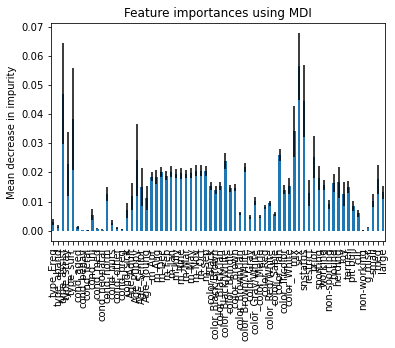

In [68]:
forest_importances = pd.Series(importances, index=feature_names)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.show()


In [69]:
#Try GradientBoostingClassifier to try another ensemble learning method

from sklearn.ensemble import GradientBoostingClassifier

# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=100,
                                            learning_rate=learning_rate,
                                            max_features=8,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.607
Accuracy score (validation): 0.604

Learning rate:  0.1
Accuracy score (training): 0.612
Accuracy score (validation): 0.607

Learning rate:  0.25
Accuracy score (training): 0.616
Accuracy score (validation): 0.610

Learning rate:  0.5
Accuracy score (training): 0.620
Accuracy score (validation): 0.609

Learning rate:  0.75
Accuracy score (training): 0.300
Accuracy score (validation): 0.299

Learning rate:  1
Accuracy score (training): 0.359
Accuracy score (validation): 0.358



In [70]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=100,
                                        learning_rate=0.25,
                                        max_features=8,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train, y_train)

# Make Prediction
predictions = classifier.predict(X_test)

In [71]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    classifier.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    classifier.score(X_test,y_test)))
print(classification_report(y_test, predictions))

Accuracy score (training): 0.616
Accuracy score (validation): 0.610
                 precision    recall  f1-score   support

       Adoption       0.61      0.85      0.71      9096
           Died       1.00      0.02      0.03        57
     Euthanasia       0.54      0.10      0.17       436
Return to Owner       0.63      0.64      0.63      5030
       Transfer       0.52      0.11      0.18      4064

       accuracy                           0.61     18683
      macro avg       0.66      0.34      0.35     18683
   weighted avg       0.60      0.61      0.56     18683



In [72]:
#Create confusion amtrix for Gradient Boosting Classifier
cm1=confusion_matrix(y_test, predictions)
cm1_df = pd.DataFrame(cm1,index = ["Adoption", "Died", "Euthanasia", "Return to Owner", "Transfer"], 
                      columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])
cm1_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Adoption,7699,0,9,1134,254
Died,31,1,2,7,16
Euthanasia,218,0,44,116,58
Return to Owner,1731,0,9,3210,80
Transfer,2983,0,18,618,445


In [77]:
#Decided to check PCAs, to see if that could be used to reduce features but keep maximum information
#Initialize PCA
pca=PCA(n_components=10)
#Apply to X
X_pca=pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.11347106 0.08560598 0.07850498 0.05905969 0.04321318 0.03766688
 0.03267177 0.0278683  0.02720968 0.02370396]
0.5289754915845029


In [79]:
#Try higher n_components because so little variance is explained. Total features in X is 68
pca=PCA(n_components=30)
#Apply to X
X_pca=pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.11347106 0.08560599 0.07850504 0.05906024 0.04321797 0.0376817
 0.03269346 0.02795161 0.02731147 0.02390799 0.02290621 0.02178066
 0.0203055  0.01992403 0.01915422 0.01797802 0.01677926 0.01627337
 0.01593872 0.01572528 0.01531238 0.01519159 0.01483842 0.0145385
 0.01439592 0.01438271 0.01416744 0.01391098 0.01350073 0.01302284]
0.8594333126446465


In [82]:
#Create dataframe from pcas
X_pca_df=pd.DataFrame(data=X_pca, columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9",
                     "PC10","PC11","PC12","PC13","PC14","PC15","PC16","PC17","PC18","PC19","PC20",
                        "PC21","PC22","PC23","PC24","PC25","PC26","PC27","PC28","PC29","PC30"])
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,0.272308,0.488875,0.813416,-0.026627,-0.516733,-0.622512,-0.585483,0.645703,0.711861,-0.782540,...,-0.173811,0.006501,-0.152304,-0.377855,0.681620,-0.346043,-0.345596,-0.036727,-0.034041,-0.051150
1,0.346769,0.606201,1.053177,0.048648,-0.547247,-0.766038,-0.616351,0.274223,0.676367,-0.544803,...,0.654177,-0.398809,0.397880,0.073478,0.027725,-0.101022,-0.062373,0.073384,-0.062342,-0.086613
2,0.244052,0.259471,0.490606,-0.383956,-0.478973,-0.916417,-0.614093,-0.552481,0.637975,0.107504,...,0.671335,-0.311588,0.223906,-0.000586,-0.021829,-0.013414,0.001039,-0.009069,-0.113304,-0.083681
3,-0.756680,0.973232,0.768466,0.511645,-0.451911,-0.017802,0.326581,0.303460,-0.123084,0.694771,...,0.084185,0.068162,-0.128284,-0.011330,0.015616,0.062553,0.105071,0.005371,0.097063,0.992371
4,-0.532767,0.793667,0.475124,0.042731,-0.437269,-0.201040,0.853589,0.736096,-0.012639,0.515551,...,-0.664693,-0.588678,0.476785,0.082931,0.154241,-0.013475,-0.167651,0.070806,0.039138,-0.077100


In [84]:
#Split into training and testing sets, using PCA df
X_train, X_test, y_train, y_test=train_test_split(X_pca_df,y1,random_state=0)

In [85]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=100, random_state=0)
#Fit classifier to training set
rf_model= rf_model.fit(X_train, y_train)
#Make prediction
predictions2 = rf_model.predict(X_test)
#Evaluate model
cm2=confusion_matrix(y_test, predictions2)
cm2_df = pd.DataFrame(cm2, index = ["Adoption", "Died", "Euthanasia", "Return to Owner", "Transfer"], 
                      columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])
cm2_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Adoption,6772,2,40,1349,933
Died,32,1,3,8,13
Euthanasia,185,1,26,132,92
Return to Owner,1624,0,32,3059,315
Transfer,2475,4,28,660,897


In [86]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    rf_model.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    rf_model.score(X_test,y_test)))
print(classification_report(y_test, predictions2))

Accuracy score (training): 0.870
Accuracy score (validation): 0.576
                 precision    recall  f1-score   support

       Adoption       0.61      0.74      0.67      9096
           Died       0.12      0.02      0.03        57
     Euthanasia       0.20      0.06      0.09       436
Return to Owner       0.59      0.61      0.60      5030
       Transfer       0.40      0.22      0.28      4064

       accuracy                           0.58     18683
      macro avg       0.38      0.33      0.34     18683
   weighted avg       0.55      0.58      0.55     18683



In [87]:
# Same GrafientBoosting, but with PCAs
classifier = GradientBoostingClassifier(n_estimators=100,
                                        learning_rate=0.25,
                                        max_features=8,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train, y_train)

# Make Prediction
predictions3 = classifier.predict(X_test)
cm3=confusion_matrix(y_test, predictions3)
cm3_df = pd.DataFrame(cm3, index = ["Adoption", "Died", "Euthanasia", "Return to Owner", "Transfer"], 
                      columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])
cm3_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Adoption,7635,17,32,1145,267
Died,30,1,0,7,19
Euthanasia,209,4,29,111,83
Return to Owner,1736,9,31,3162,92
Transfer,3014,6,38,600,406


In [88]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    classifier.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    classifier.score(X_test,y_test)))
print(classification_report(y_test, predictions3))

Accuracy score (training): 0.629
Accuracy score (validation): 0.601
                 precision    recall  f1-score   support

       Adoption       0.60      0.84      0.70      9096
           Died       0.03      0.02      0.02        57
     Euthanasia       0.22      0.07      0.10       436
Return to Owner       0.63      0.63      0.63      5030
       Transfer       0.47      0.10      0.16      4064

       accuracy                           0.60     18683
      macro avg       0.39      0.33      0.32     18683
   weighted avg       0.57      0.60      0.55     18683



# Three Group Outcome

In [64]:
#Factorize outcome
#factor=pd.factorize(data["newOut"])
#data["outcome"]=factor[0]
#outcome_definitions=factor[1]
#outcome_definitions

Index(['rto', 'adopted', 'euth', 'died'], dtype='object')

In [89]:
#Split into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X,y2,random_state=0)

In [90]:
#Random Forest model for y2, the 3 category outcome

from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=100, random_state=0)
#Fit classifier to training set
rf_model= rf_model.fit(X_train, y_train)
#Make prediction
predictions = rf_model.predict(X_test)
#Evaluate model
cm=confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index = ["Adoption", "Death", "Return to Owner"], 
                      columns=["Predicted 0", "Predicted 1", "Predicted 2"])
cm_df


,Predicted 0,Predicted 1,Predicted 2
Adoption,11487,69,1604
Death,342,43,108
Return to Owner,2280,32,2718


In [91]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    rf_model.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    rf_model.score(X_test,y_test)))
print(classification_report(y_test, predictions))

Accuracy score (training): 0.934
Accuracy score (validation): 0.763
              precision    recall  f1-score   support

 Adopt/Trans       0.81      0.87      0.84     13160
       Death       0.30      0.09      0.14       493
      Return       0.61      0.54      0.57      5030

    accuracy                           0.76     18683
   macro avg       0.58      0.50      0.52     18683
weighted avg       0.75      0.76      0.75     18683



In [94]:
#Feature importances for random forest model
#Get top 10 features from random forest model
importances = rf_model.feature_importances_
feature_names=coded_data.columns

d={"feature": feature_names,"importance":importances}
importance_df=pd.DataFrame(d).sort_values(by="importance", ascending=False)
importance_df.head(10)

,feature,importance
2,type_assist,0.077338
51,snstatus,0.067878
4,type_surr,0.062321
50,sex,0.041661
3,type_stray,0.037302
49,mix,0.032547
17,Age_Puppy,0.031636
53,prior,0.030905
18,Age_Senior,0.022508
46,color_Tan,0.021726


In [92]:
# Same GrafientBoosting, but y2
classifier = GradientBoostingClassifier(n_estimators=100,
                                        learning_rate=0.25,
                                        max_features=8,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train, y_train)

# Make Prediction
predictions1 = classifier.predict(X_test)
cm1=confusion_matrix(y_test, predictions1)
cm1_df = pd.DataFrame(cm1, index = ["Adoption", "Death", "Return to Owner"], 
                      columns=["Predicted 0", "Predicted 1", "Predicted 2"])
cm1_df

,Predicted 0,Predicted 1,Predicted 2
Adoption,11789,17,1354
Death,359,36,98
Return to Owner,2175,3,2852


In [93]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    classifier.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    classifier.score(X_test,y_test)))
print(classification_report(y_test, predictions1))

Accuracy score (training): 0.789
Accuracy score (validation): 0.786
              precision    recall  f1-score   support

 Adopt/Trans       0.82      0.90      0.86     13160
       Death       0.64      0.07      0.13       493
      Return       0.66      0.57      0.61      5030

    accuracy                           0.79     18683
   macro avg       0.71      0.51      0.53     18683
weighted avg       0.78      0.79      0.77     18683

